Portfolio Optimization using Markowitz Model
================================
- Markowitz Model: A mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk. It emphasizes diversification to reduce risk.
- Efficient Frontier: A curve representing the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return.
- Sharpe Ratio: A measure of risk-adjusted return, calculated as (Portfolio Return - Risk-Free Rate) / Portfolio Standard Deviation. A higher Sharpe ratio indicates better risk-adjusted performance.
- Sortino Ratio: Similar to the Sharpe ratio, but it only considers downside risk (negative returns). It is calculated as (Portfolio Return - Risk-Free Rate) / Downside Deviation. A higher Sortino ratio indicates better risk-adjusted performance with a focus on downside risk.

In [35]:
# Fetch historical SP 500 and Bond data
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm   
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Fetch historical data for VOO (S&P 500 ETF) and BLV (Bond ETF)
# VOO is used as a proxy for the S&P 500 index
# BLV is used as a proxy for long-term bonds
voo = yf.download('VOO', start='2011-01-01', end='2026-01-01')
blv = yf.download('BLV', start='2011-01-01', end='2026-01-01')
sp500 = voo['Close']
bonds = blv['Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [48]:
sp500

Ticker,VOO
Date,
2011-01-03,89.203102
2011-01-04,89.126312
2011-01-05,89.602211
2011-01-06,89.448669
2011-01-07,89.264503
...,...
2025-09-25,604.860229
2025-09-26,608.419983
2025-09-29,610.130005


In [49]:
bonds

Ticker,BLV
Date,
2011-01-03,41.946381
2011-01-04,41.835159
2011-01-05,41.268185
2011-01-06,41.363575
2011-01-07,41.564907
...,...
2025-09-25,70.529999
2025-09-26,70.529999
2025-09-29,71.010002


In [ ]:
# Data information
sp500.info()
bonds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3789 entries, 2010-09-09 to 2025-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VOO     3789 non-null   float64
dtypes: float64(1)
memory usage: 59.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3961 entries, 2010-01-04 to 2025-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BLV     3961 non-null   float64
dtypes: float64(1)
memory usage: 61.9 KB


In [51]:
# Combine into a single DataFrame
data = pd.concat([sp500, bonds], axis=1)
data.columns = ['S&P 500', 'Bonds']
data

,S&P 500,Bonds
Date,,
2011-01-03,89.203102,41.946381
2011-01-04,89.126312,41.835159
2011-01-05,89.602211,41.268185
2011-01-06,89.448669,41.363575
2011-01-07,89.264503,41.564907
...,...,...
2025-09-25,604.860229,70.529999
2025-09-26,608.419983,70.529999
2025-09-29,610.130005,71.010002


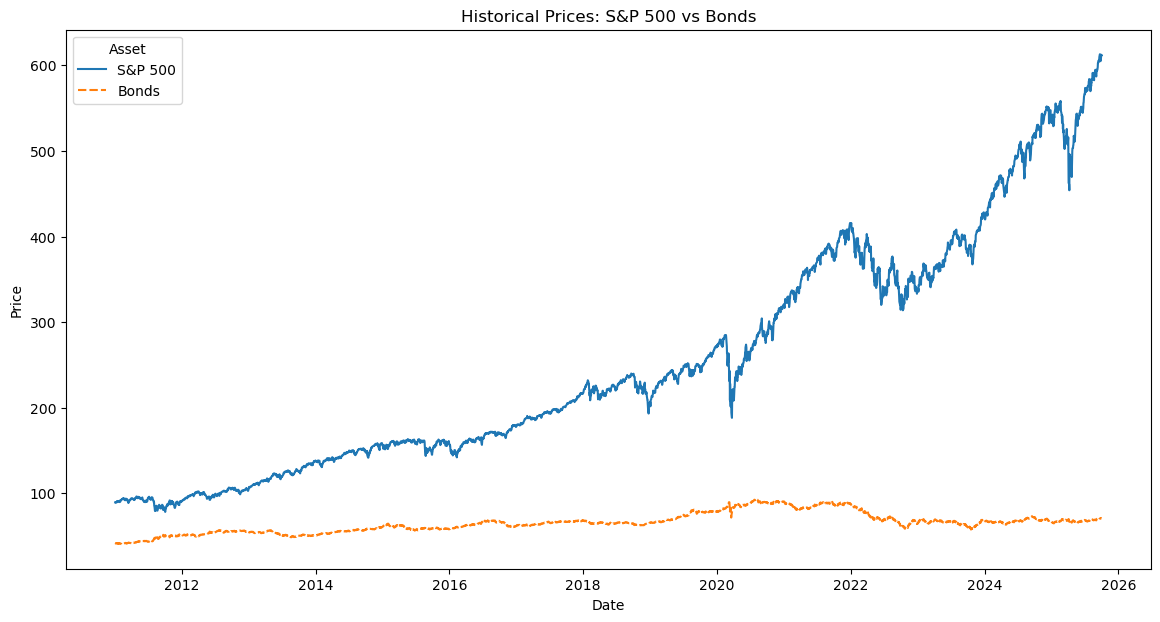

In [53]:
# Plot historical prices
plt.figure(figsize=(14, 7))
sns.lineplot(data=data)
plt.title('Historical Prices: S&P 500 vs Bonds')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Asset')
plt.show()

In [ ]:
# Calculate daily returns
daily_returns = data.pct_change().dropna()
daily_returns

,S&P 500,Bonds
Date,,
2011-01-04,-0.000861,-0.002652
2011-01-05,0.005340,-0.013553
2011-01-06,-0.001714,0.002311
2011-01-07,-0.002059,0.004867
2011-01-10,-0.000860,0.002549
...,...,...
2025-09-25,-0.004774,-0.001416
2025-09-26,0.005885,0.000000
2025-09-29,0.002811,0.006806


Monthly Closed Prices
---------------------

In [67]:
# Monthly closing prices data
monthly = data.resample('MS').first()
monthly_returns = monthly.pct_change().dropna()

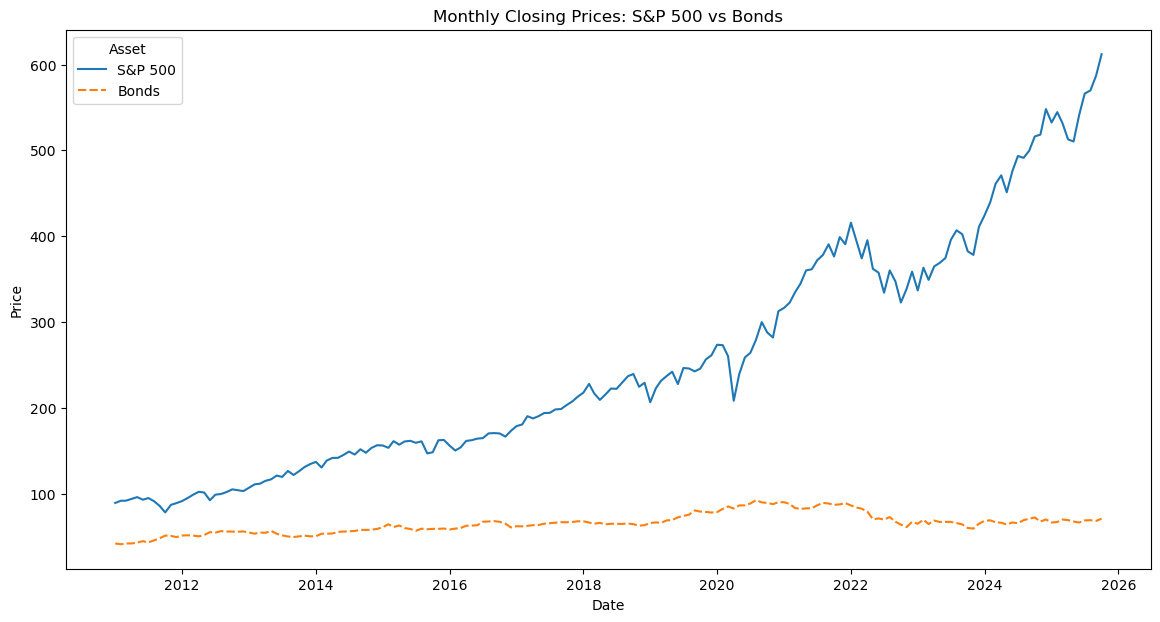

In [68]:
# Line plot of historical prices
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly)
plt.title('Monthly Closing Prices: S&P 500 vs Bonds')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Asset')
plt.show()


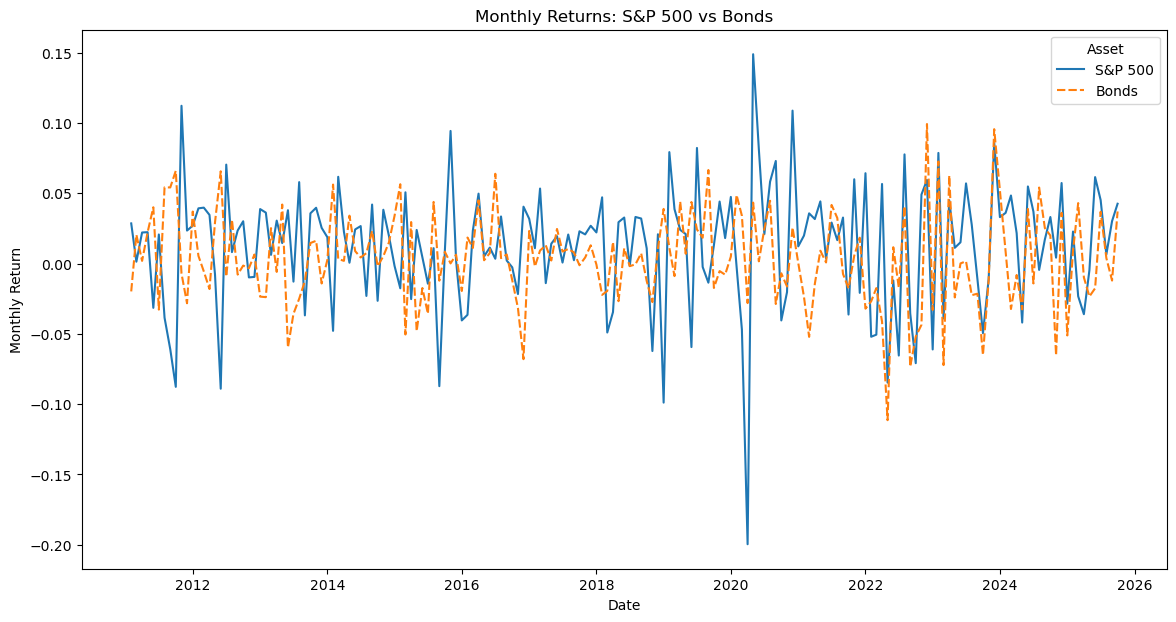

In [66]:
# Plot monthly returns
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_returns)
plt.title('Monthly Returns: S&P 500 vs Bonds')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.legend(title='Asset')
plt.show()

In [85]:
# Mean of monthly returns
mean_monthly_returns = monthly_returns.mean()
mean_monthly_returns

S&P 500    0.011917
Bonds      0.003499
dtype: float64

In [70]:
# Variance of monthly returns
var_monthly_returns = monthly_returns.var()
var_monthly_returns

S&P 500    0.001937
Bonds      0.001079
dtype: float64

In [71]:
# Calculate standard deviation of monthly returns
std_monthly_returns = monthly_returns.std()
std_monthly_returns

S&P 500    0.044015
Bonds      0.032845
dtype: float64

In [76]:
# Annualized Risk free rate
us_treasury_10yr_rate = yf.Ticker("^TNX").history(period="1d")['Close'][0] / 100
us_treasury_10yr_rate

0.041080002784729

In [73]:
# Monthly risk-free rate
monthly_risk_free_rate = (1 + us_treasury_10yr_rate) ** (1/12) - 1
monthly_risk_free_rate

0.0033653388432954845

In [74]:
# Calculate Sharpe Ratio
sharpe_ratio = (mean_monthly_returns - monthly_risk_free_rate) / std_monthly_returns
sharpe_ratio

S&P 500    0.194296
Bonds      0.004059
dtype: float64

In [75]:
# Calculate Sortino Ratio
downside_std = monthly_returns[monthly_returns < 0].std()
sortino_ratio = (mean_monthly_returns - monthly_risk_free_rate) / downside_std
sortino_ratio

S&P 500    0.254501
Bonds      0.006414
dtype: float64

In [77]:
# Calculate corvariance matrix
cov_matrix = monthly_returns.cov()
cov_matrix

,S&P 500,Bonds
S&P 500,0.001937,0.000193
Bonds,0.000193,0.001079


In [78]:
# Calculate corvariance
covariance = monthly_returns.iloc[:, 0].cov(monthly_returns.iloc[:, 1])
covariance

0.00019263092859439916

In [80]:
# Calculate correlation matrix
correlation_matrix = monthly_returns.corr()
correlation_matrix

,S&P 500,Bonds
S&P 500,1.000000,0.133247
Bonds,0.133247,1.000000


In [ ]:
# Calculate correlation
correlation = monthly_returns.iloc[:, 0].corr(monthly_returns.iloc[:, 1])
correlation

0.1332473758058957

Calculate Sharpe Ratio for two-asset portfolio
---------------------

In [82]:
# Portfolio
portfolio_weights = {
                    'portfolio_1': [0 , 1],
                    'portfolio_2': [0.1, 0.9],
                    'portfolio_3': [0.2, 0.8],
                    'portfolio_4': [0.3, 0.7],
                    'portfolio_5': [0.4, 0.6],
                    'portfolio_6': [0.5, 0.5],
                    'portfolio_7': [0.6, 0.4],
                    'portfolio_8': [0.7, 0.3],
                    'portfolio_9': [0.8, 0.2],
                    'portfolio_10': [0.9, 0.1],
                    'portfolio_11': [1, 0]
                    }

In [91]:
# Calculate mean returns for each portfolio
mean_returns = {}
for name, weights in portfolio_weights.items():
    weights = np.array(weights)
    mean_return = np.sum(mean_monthly_returns * weights)
    mean_returns[name] = np.round(mean_return, 4)

mean_returns

{'portfolio_1': 0.0035,
 'portfolio_2': 0.0043,
 'portfolio_3': 0.0052,
 'portfolio_4': 0.006,
 'portfolio_5': 0.0069,
 'portfolio_6': 0.0077,
 'portfolio_7': 0.0085,
 'portfolio_8': 0.0094,
 'portfolio_9': 0.0102,
 'portfolio_10': 0.0111,
 'portfolio_11': 0.0119}

In [92]:
# Calculate variance returns for each portfolio
portfolio_variances = {}
for name, weights in portfolio_weights.items():
    weights = np.array(weights)
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_variances[name] = np.round(variance, 6)

portfolio_variances

{'portfolio_1': 0.001079,
 'portfolio_2': 0.000928,
 'portfolio_3': 0.00083,
 'portfolio_4': 0.000784,
 'portfolio_5': 0.000791,
 'portfolio_6': 0.00085,
 'portfolio_7': 0.000962,
 'portfolio_8': 0.001127,
 'portfolio_9': 0.001345,
 'portfolio_10': 0.001615,
 'portfolio_11': 0.001937}

In [93]:
# Calculate standard deviation returns for each portfolio
portfolio_std_devs = {}
for name, weights in portfolio_weights.items():
    weights = np.array(weights)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    portfolio_std_devs[name] = np.round(std_dev, 6)

portfolio_std_devs

{'portfolio_1': 0.032845,
 'portfolio_2': 0.030461,
 'portfolio_3': 0.028802,
 'portfolio_4': 0.027998,
 'portfolio_5': 0.028121,
 'portfolio_6': 0.029161,
 'portfolio_7': 0.031024,
 'portfolio_8': 0.033575,
 'portfolio_9': 0.03667,
 'portfolio_10': 0.040183,
 'portfolio_11': 0.044015}

In [94]:
# Create a DataFrame to summarize portfolio metrics
portfolio_summary = pd.DataFrame({
    'Portfolio': portfolio_weights.keys(),
    'Mean Return': mean_returns.values(),
    'Variance': portfolio_variances.values(),
    'Standard Deviation': portfolio_std_devs.values()
})

portfolio_summary

,Portfolio,Mean Return,Variance,Standard Deviation
0,portfolio_1,0.0035,0.001079,0.032845
1,portfolio_2,0.0043,0.000928,0.030461
2,portfolio_3,0.0052,0.000830,0.028802
3,portfolio_4,0.0060,0.000784,0.027998
4,portfolio_5,0.0069,0.000791,0.028121
5,portfolio_6,0.0077,0.000850,0.029161
6,portfolio_7,0.0085,0.000962,0.031024
7,portfolio_8,0.0094,0.001127,0.033575
8,portfolio_9,0.0102,0.001345,0.036670
9,portfolio_10,0.0111,0.001615,0.040183


In [95]:
# Calculate Sharpe ratio for each portfolio
portfolio_summary['Sharpe Ratio'] = (portfolio_summary['Mean Return'] - monthly_risk_free_rate) / portfolio_summary['Standard Deviation']
portfolio_summary

,Portfolio,Mean Return,Variance,Standard Deviation,Sharpe Ratio
0,portfolio_1,0.0035,0.001079,0.032845,0.004100
1,portfolio_2,0.0043,0.000928,0.030461,0.030684
2,portfolio_3,0.0052,0.000830,0.028802,0.063699
3,portfolio_4,0.0060,0.000784,0.027998,0.094102
4,portfolio_5,0.0069,0.000791,0.028121,0.125695
5,portfolio_6,0.0077,0.000850,0.029161,0.148646
6,portfolio_7,0.0085,0.000962,0.031024,0.165506
7,portfolio_8,0.0094,0.001127,0.033575,0.179737
8,portfolio_9,0.0102,0.001345,0.036670,0.186383
9,portfolio_10,0.0111,0.001615,0.040183,0.192486


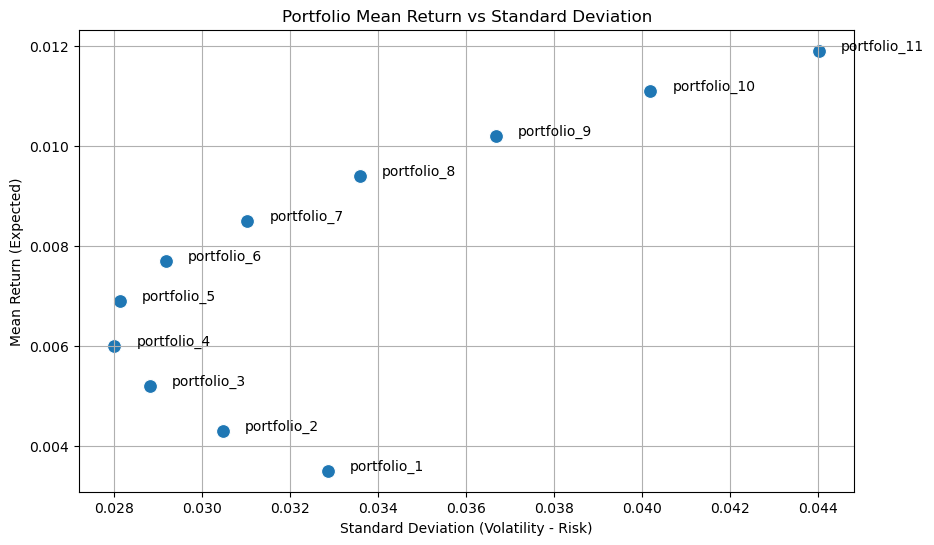

In [ ]:
# Scatter plot of mean return vs standard deviation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Standard Deviation', y='Mean Return', data=portfolio_summary, s=100)
for i in range(portfolio_summary.shape[0]):
    plt.text(x=portfolio_summary['Standard Deviation'][i]+0.0005, 
             y=portfolio_summary['Mean Return'][i], 
             s=portfolio_summary['Portfolio'][i])
plt.title('Portfolio Mean Return vs Standard Deviation')
plt.xlabel('Standard Deviation (Volatility - Risk)')
plt.ylabel('Mean Return (Expected')
plt.grid()
plt.show()

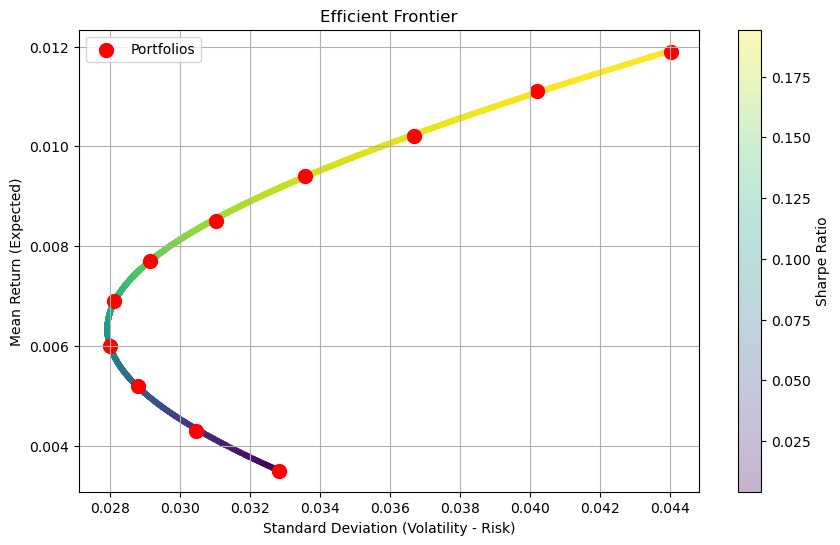

In [100]:
# Effecient Frontier
# Generate random portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(2)
    weights /= np.sum(weights)
    mean_return = np.sum(mean_monthly_returns * weights)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    results[0,i] = std_dev
    results[1,i] = mean_return
    results[2,i] = (mean_return - monthly_risk_free_rate) / std_dev  # Sharpe Ratio
# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(portfolio_summary['Standard Deviation'], portfolio_summary['Mean Return'], color='red', s=100, label='Portfolios')
plt.title('Efficient Frontier')
plt.xlabel('Standard Deviation (Volatility - Risk)')
plt.ylabel('Mean Return (Expected)')
plt.legend()
plt.grid()
plt.show()

In [102]:
results.shape

(3, 10000)